<a href="https://colab.research.google.com/github/kanaka-22/Fruit-Classification-with-Fast-AI/blob/main/Fruit_Classification_with_Fast_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import cv2
import sklearn
from PIL import Image
from pathlib import Path
from fastai.vision.all import *
from fastai.callback import *
from fastai.metrics import error_rate
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path =Path("/content/drive/MyDrive/Fruits")
path.ls()

(#6) [Path('/content/drive/MyDrive/Fruits/fresh_pomegranates_done'),Path('/content/drive/MyDrive/Fruits/rotten_pomegranates_done'),Path('/content/drive/MyDrive/Fruits/rotten_strawberries_done'),Path('/content/drive/MyDrive/Fruits/fresh_strawberries_done'),Path('/content/drive/MyDrive/Fruits/fresh_peaches_done'),Path('/content/drive/MyDrive/Fruits/rotten_peaches_done')]

In [ ]:
files = list(path.glob("*/*.jpg"))

print(f'Total Images = {len(files)}')

Total Images = 1655


In [ ]:
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.2,
                                          item_tfms=Resize(460),
                                          batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

In [ ]:
len(dls.train_ds)

1324

In [ ]:
len(dls.valid_ds)

331

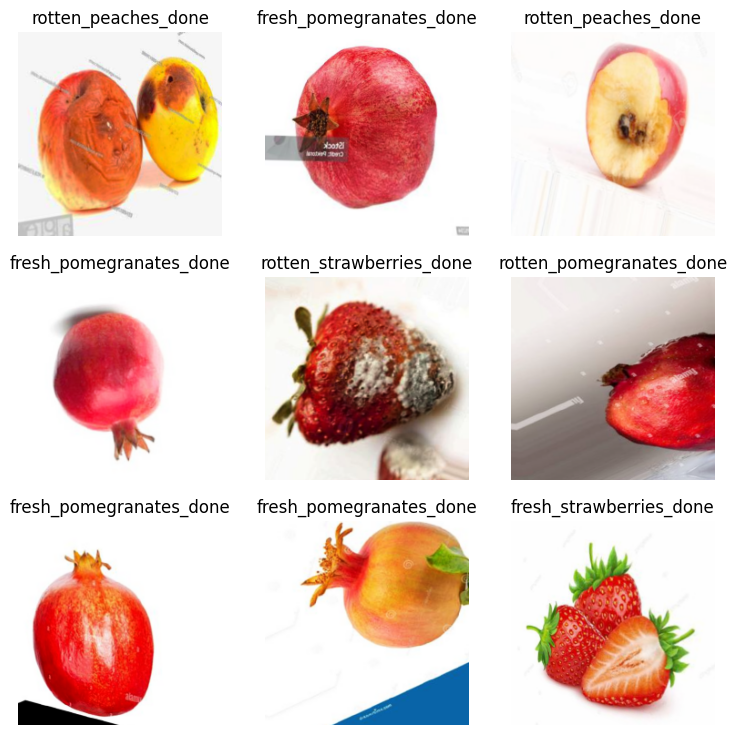

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 65.4MB/s]


In [ ]:
learn.model_dir = "/kaggle/working/"

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

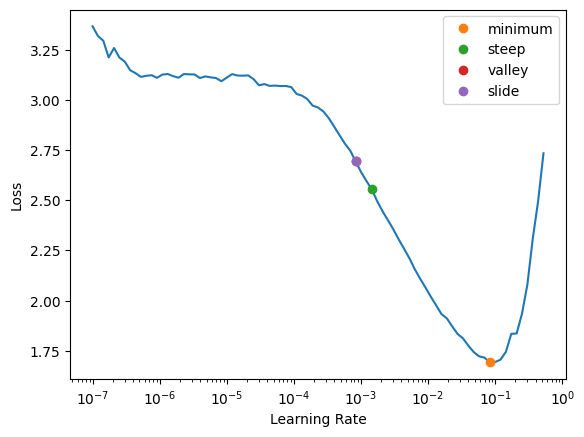

In [ ]:
suggest_funcs = (minimum, steep, valley, slide)

lrs = learn.lr_find(suggest_funcs=suggest_funcs)

In [ ]:
lrs

SuggestedLRs(minimum=0.00831763744354248, steep=0.0014454397605732083, valley=0.0008317637839354575, slide=0.0008317637839354575)

epoch,train_loss,valid_loss,accuracy,time
0,2.317122,0.594337,0.800604,10:44
1,1.344316,0.317338,0.900302,09:24
2,0.928160,0.282767,0.912387,09:18
3,0.680735,0.249190,0.918429,09:20
4,0.540140,0.242877,0.921450,09:16


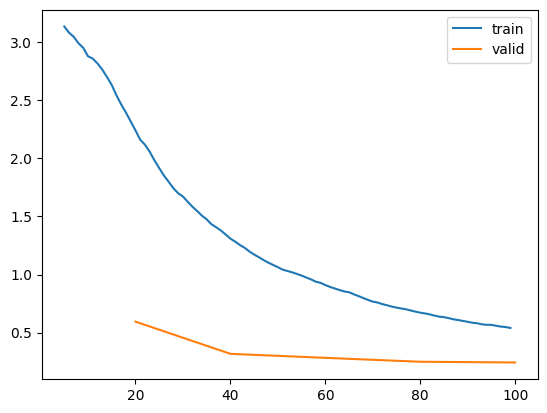

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

In [ ]:
learn.predict(files[0])

('fresh_pomegranates_done',
 tensor(1),
 tensor([6.6929e-04, 9.9257e-01, 9.1074e-04, 2.6757e-03, 2.2933e-03, 8.8158e-04]))

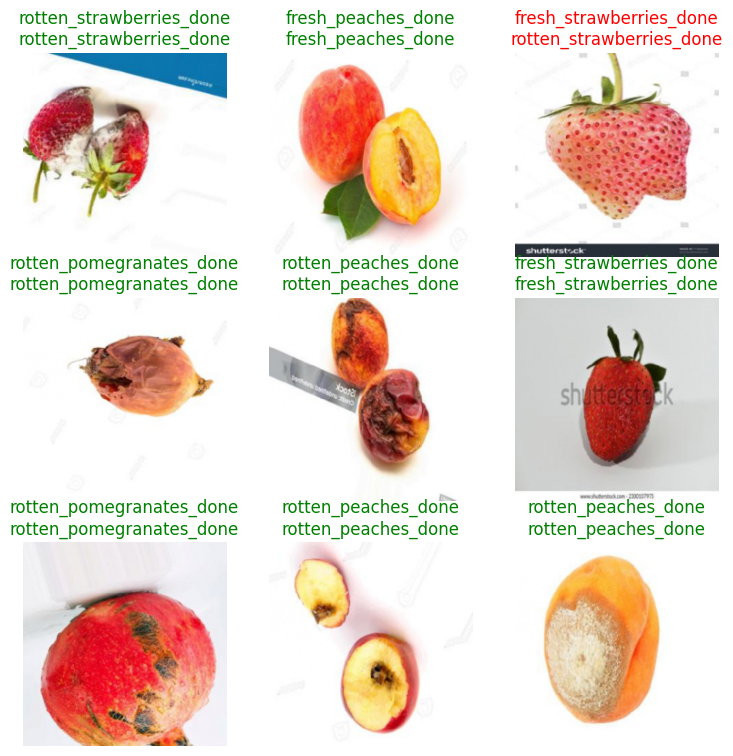

In [ ]:
learn.show_results()

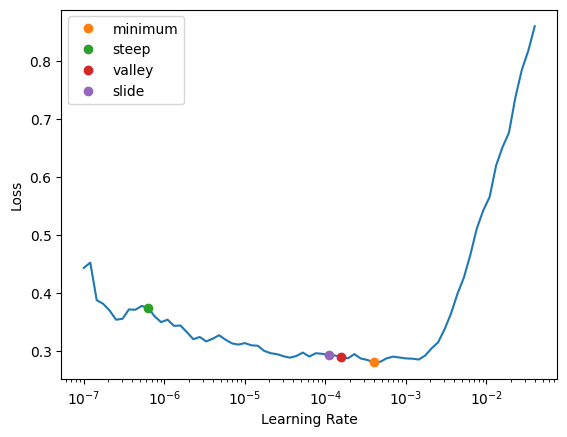

In [ ]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lrs

SuggestedLRs(minimum=3.981071640737355e-05, steep=6.309573450380412e-07, valley=0.00015848931798245758, slide=0.00010964782268274575)

epoch,train_loss,valid_loss,accuracy,time
0,0.308570,0.232792,0.912387,13:22
1,0.265777,0.250832,0.909366,13:21
2,0.221185,0.509136,0.854985,13:20
3,0.200863,0.184670,0.945619,13:21
4,0.166291,0.199879,0.921450,13:24
5,0.133570,0.124531,0.954683,13:23
6,0.103365,0.126599,0.960725,13:20
7,0.078546,0.092782,0.972810,13:31
8,0.060365,0.084628,0.972810,13:27
9,0.049226,0.088535,0.975831,13:27


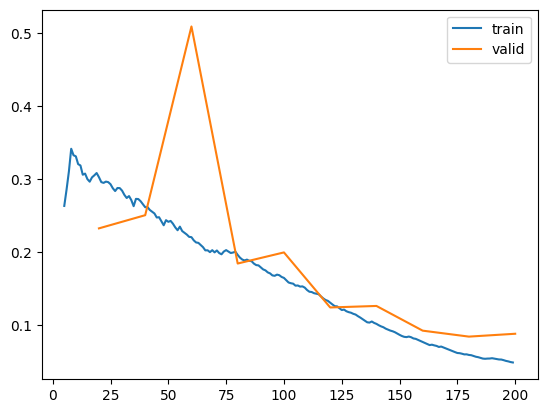

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

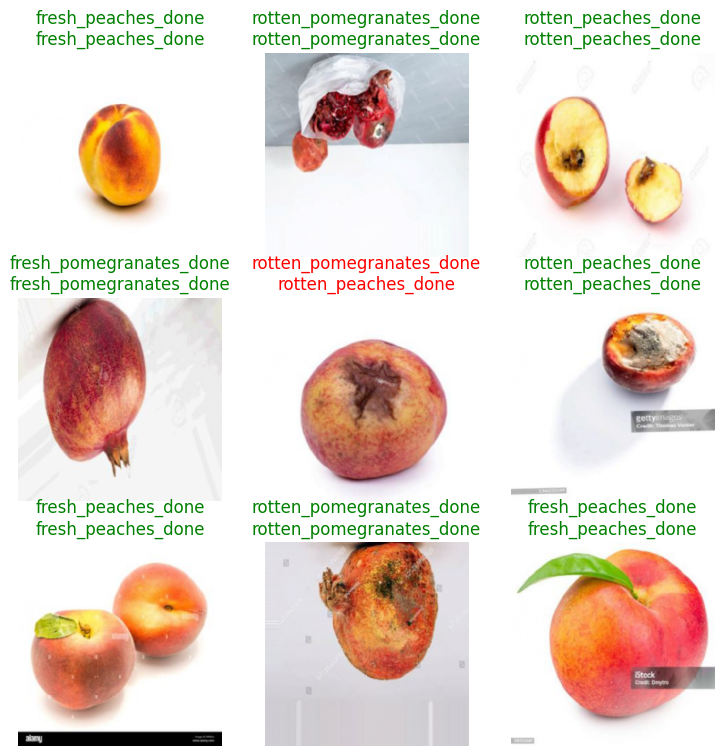

In [ ]:
learn.show_results()

In [ ]:
preds, targets = learn.get_preds()

class_report = classification_report(targets, torch.argmax(preds, dim=1), target_names=dls.vocab)
print(class_report)

                          precision    recall  f1-score   support

      fresh_peaches_done       1.00      1.00      1.00        48
 fresh_pomegranates_done       0.98      0.98      0.98        58
 fresh_strawberries_done       1.00      0.95      0.98        66
     rotten_peaches_done       0.96      1.00      0.98        65
rotten_pomegranates_done       0.98      0.93      0.95        54
rotten_strawberries_done       0.93      1.00      0.96        40

                accuracy                           0.98       331
               macro avg       0.97      0.98      0.98       331
            weighted avg       0.98      0.98      0.98       331



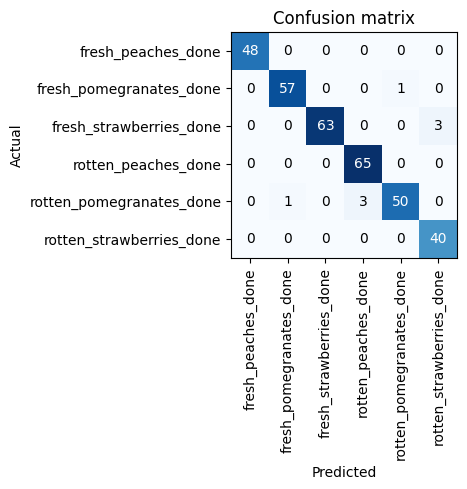

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

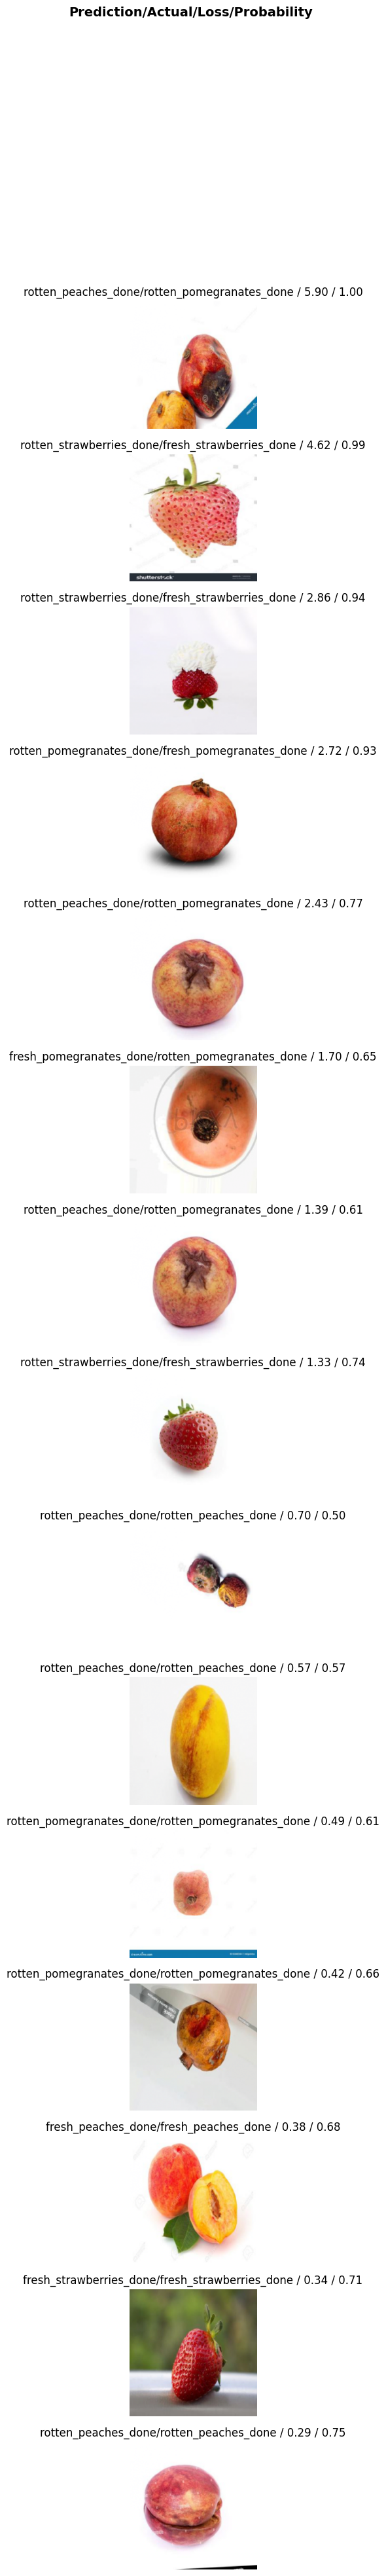

In [ ]:
interp = Interpretation.from_learner(learn)

interp.plot_top_losses(15, nrows=15)